# Problem sheet 3 - Q3: $\ell_{1}$-regularisation

1. [Coordinate descent implementation](#1)
2. [Evaluation](#2)
3. [Next steps](#3)

In a previous exercise we implemented gradient descent to minimise a loss function with an $\ell_{2}$-regularisation term. In this exercise we wish to construct an algorithm to minimise $\ell_{1}$-loss instead. That is, let
$$J(\theta) = \tfrac{1}{2}(X\theta-y)^{T}(X\theta-y) + \lambda\lVert\theta\rVert_{1},$$
where $X$ is the design matrix of our input data, $y$ are the labels, $\lambda$ is a hyperparameter that controls the strength of regularisation, $\theta$ is the parameter vector that we want to learn and $\lVert\cdot\rVert_{1}$ denotes the $\ell_{1}$-norm. $\ell_{1}$-regularisation can be useful, because it often results in sparse solutions (unlike the $\ell_{2}$-loss). As a heuristic, consider the two curves:
![l1 vs l2 loss](l1l2_loss.jpg "l1 vs l2 loss")
Now suppose that during gradient descent some of the variables that we are optimising start approaching zero. If we  use $\ell_{2}$-regularisation then we see that the corresponding gradients will also approach zero, which slows down the decay. On the other hand, for $\ell_{1}$-regularisation the gradient (where it exists) is piecewise-constant and thus for any decent classifier (where the loss is small) we expect that many weights are pushed down all the way to 0. Notice it is also possible to understand this phenomenon by considering the dual problem of minimising the unregularised loss subject to the $\ell_{1}$-constraint $|\theta_{i}|\leq L$ for some fixed $L$ in which case the optimal contours of the loss (subject to the constraint) often fall on the axes.

For this question we simulate our data as follows. First we generate 50 training data points by sampling from the multivariate normal distribution $N(0, I)$ and we also create the "true" sparse feature vector `theta_star` by using `scipy.sparse.random`. Finally, we construct the labels with the formula $y=X\theta + 0.05\Omega$, where the elements of $\Omega$ are iid $\omega_{i}\sim N(0, 1)$.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
plt.rcParams["mathtext.fontset"] = "dejavuserif"
from scipy.sparse import random as sparse_random

dim = 100
samples = 20
rng = np.random.default_rng()

X = rng.multivariate_normal(np.zeros(dim), np.identity(dim) * 1, size=samples)
theta_star = sparse_random(dim, 1, density=0.1).toarray().ravel()
y = (X @ theta_star + 0.05 * rng.standard_normal((samples))).ravel()

## 1. Coordinate descent implementation <a id="1"></a>

Optimising cost functions with $\ell_{1}$-terms is difficult, because they are no longer differentiable. To overcome this we use two tricks:
1. We optimise $J(\theta)$ with respect to only one coordinate at a time, say, $\theta_{i}$.
2. For this choice our objective function contains the non-differentiable term $|\theta_{i}|=\mathop{\mathrm{sgn}}(\theta_{i})\cdot\theta_{i}$. We separately consider both cases for the sign, compute the optimal $\theta_{i}$ in either case and keep the one which minimises $J(\theta)$.

In [2]:
def cost(X, y, theta, l):
    return 0.5 * np.sum(np.power((X @ theta - y), 2)) + l * np.sum(np.abs(theta))

def coordDescent(X, y, l=0.1):   
    change = 1
    theta = np.ones(X.shape[1])
    
    while change > 10e-5:
        theta_old = theta.copy()
        for i in range(len(theta)):
            theta_tilde = np.copy(theta)
            theta_tilde[i] = 0
            X_i = X[:, i]
            num = - X_i.T @ (X @ theta_tilde - y)
            denom = X_i.T @ X_i
            
            # we have to make sure that in the positive case the potential theta is actually positive
            # and vice versa
            theta_i_pos = max((num - l) / denom, 0)
            theta_i_neg = min((num + l) / denom, 0)

            theta_tilde_pos = np.copy(theta_tilde)
            theta_tilde_pos[i] = theta_i_pos
            theta_tilde_neg = np.copy(theta_tilde)
            theta_tilde_neg[i] = theta_i_neg

            if cost(X, y, theta_tilde_pos, l) <= cost(X, y, theta_tilde_neg, l):
                theta[i] = theta_i_pos
            else:
                theta[i] = theta_i_neg
        change = np.linalg.norm(theta_old - theta)
        
    return theta, cost(X, y, theta, l)

## 2. Evaluation<a id="2"></a>

We'll now apply our algorithm to the dataset that we generated for different values of $\lambda$. We see that the performance increases roughly linearly as we decrease $\lambda$ at the cost of longer training times.

In [3]:
%%time
# we create a list of regularisation parameters weighted towards the smaller end

l_range = np.square(np.linspace(sqrt(0.001), sqrt(10), 50))
costs = [None] * len(l_range)
theta_hats = [None] * len(l_range)
diffs = [None] * len(l_range)

for i, l in enumerate(l_range):
    theta_hats[i], costs[i] = coordDescent(X, y, l)
    diffs[i] = np.linalg.norm(theta_hats[i] - theta_star)

CPU times: user 7min 6s, sys: 3.58 s, total: 7min 10s
Wall time: 7min 12s


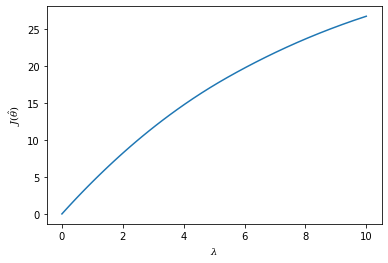

In [4]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$J(\hat{\theta})$')
ax.plot(l_range, costs)
plt.show()

Since in this example we have access to the true parameter $\theta^{\ast}$, we can also look at the performance in terms of the norm of $\hat{\theta}-\theta^{\ast}$. We can see that our model is able to perform fairly well even though we stay far from the true value of $\theta$ until $\lambda$ is very small. One explanation could be that since we are working with a high-dimensional problem, even small errors in each of the coordinates of $\theta$ can compound into a large distance from $\theta^{\ast}$ despite the resulting model being fairly accurate (cf. curse of dimensionality).

**Remark**: The compounding of $\ell_{1}$-error from small variations in high dimensional spaces is one of the key ideas for generating adversarial examples for deep neural networks.

Finally, the fact that we end up with a sparse feature vector could be used as a form of dimensionality reduction, by discarding the features where $\hat{\theta}_{i}=0$ and then training a more complicated model out of the remaining ones.

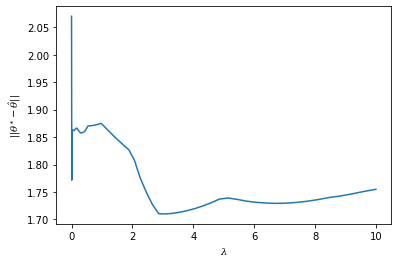

In [5]:
fig, ax = plt.subplots(figsize=(6,4))
ax.set_xlabel(r'$\lambda$')
ax.set_ylabel(r'$||\theta^{\ast}-\hat{\theta}||$')
ax.plot(l_range, diffs)
plt.show()

## 3. Next steps<a id="3"></a>

- The algorithm is rather inefficient. One way to speed it up would be to consider more than one coordinate at a time. This leads to more cases to check at each iteration, but potentially faster convergence.
- There are multiple other existing methods to minimise such loss functions (e.g. by approximating it with a differentiable one). Look into these and implement to compare performance with coordinate descent.